In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re,glob,os
# from collections import defaultdict
import dgutils
import json

# Notebook display options
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import dframe_tools as dtools
import plot_tools as ptools
import gen_resubmit as gensub

# Comment out for description of below modules
# dtools.help()
# ptools.help()
# gensub.help()

'''
Assign path of OUTPUT files and generate database
Options:
skip = int or float [int: number of line to skip, float: proportion to skip]
noenergy = 0 if you have energy estimator, 1 if you don't. 0: pick 9, 10th column 1: pick 0, 1st column
replace = 1 if you want to replace nan to zero. Be cautious to use it
'''

### If you import data from csv, put 1 here
is_csv = 1

#=========================================================================
if is_csv == 1:

#     dbase = pd.read_csv('../data/SFphase_data.csv')
    dbase = pd.read_csv('../data/lindenset.csv')
    dbase['filedic'] = dbase['filedic'].apply(lambda x: json.loads(x.replace("'", '"')))
    dbase['boxdims'] = dbase['boxdims'].apply(lambda x: [float(t) for t in x.strip('[').strip(']').split(',')])

else:
### from raw data
    path = '../data/QMC/lindenset/'
    dbase = dtools.df_pimc(path, skip = 0, noenergy = 1, replace = 1)

dfdict = ptools.datadic(dbase)

dict_keys(['0.15,-93.0'])


In [2]:
### plot style
plot_style = {'notebook':'../include/notebook.mplstyle','sans':'../include/sans_NC.mplstyle', 'aps':'../include/aps.mplstyle'}
plt.style.reload_library()
plt.style.use(plot_style['aps'])
figsize = plt.rcParams['figure.figsize']

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# setup a possible custom font path
from matplotlib import font_manager
def what_font_path (filename):
    for p in font_manager.findSystemFonts(fontpaths=None, fontext="ttf"):
        if p.find(filename) != -1:
            return p

font_path,bold_font_path = '.','.'
if 'LOCAL_FONT_PATH' in os.environ:
    font_path = os.environ['LOCAL_FONT_PATH'] + os.path.sep + 'HelveticaNeue/HelveticaNeue-Light-08.ttf'
    bold_font_path = os.environ['LOCAL_FONT_PATH'] + os.path.sep + 'HelveticaNeue/HelveticaNeue-Bold-02.ttf'
else:
    # local path (custom)
    font_path = what_font_path('HelveticaNeue-Light-08')
    bold_font_path = what_font_path('HelveticaNeue-Bold-02')

In [3]:
### Export data
# dbase.to_csv('../data/lindenset.csv',index=False)

In [4]:
def lin_ave(subset):
    if len(subset['strain'].unique()) != 1:
        print("the subset has more than one strain data")
        return None
    else:
        subset = subset.sort_values('totN', ascending=True)
        subset = subset.reset_index()

        totNlst = np.array(subset['totN'])

        lin_lst = []
        dz_lst = []

        for idx, row in subset.iterrows():
            file = row['filedic']['lineardensity'] #file location
            file = file.replace('/home/sang/UVM/H4test/','../data/QMC/')
            print(file)

            with open(file,'r') as lines:
                header = lines.readline()
                header = lines.readline()
            ngridsep = int(header.split(' ')[-1])
            dz = float(header.split(' ')[-4])
            linData = np.genfromtxt(file, skip_header=2,deletechars="") #read data
            linave = np.mean(linData, axis=0)
            lin_lst.append(linave)
            dz_lst.append(dz)
            
        return totNlst, lin_lst, dz_lst

In [5]:
target = dbase[(dbase['strain']==0.15)&(dbase['mu']==-93)&(dbase['totN']==64)&(dbase['T']==0.6)]

In [6]:
target

,id,strain,mu,T,filedic,n,nerr,totN,kap,kaperr,rhos,rhoserr,estsize,supsize,boxdims,com_ave,com_err
1,ec9ecbb7-d08b-4d3c-948d-e6eb51465abb,0.15,-93.0,0.6,{'log': '/home/sang/UVM/H4test/lindenset/gce-l...,26.88076,0.012076,64,0.249073,0.004917,0.51509,0.023465,4049,4049,"[22.62751, 19.596, 10.0]",NaN,NaN


In [7]:
totNlst, lin_lst, dz_lst = lin_ave(target)
lx, ly, lz = target['boxdims'].iloc[0]

../data/QMC/lindenset/gce-lineardensity-00.600-010.000--093.000-0.00313-ec9ecbb7-d08b-4d3c-948d-e6eb51465abb.dat


In [8]:
from scipy import interpolate
x = np.arange(0,10-dz_lst[0],dz_lst[0])
y = np.array(lin_lst[0])*dz_lst[0]*lx*ly/target['n'].iloc[0]
f = interpolate.interp1d(x, y, kind='cubic')

In [9]:
len(np.arange(0,2,dz_lst[0]))
x[20]

1.980198

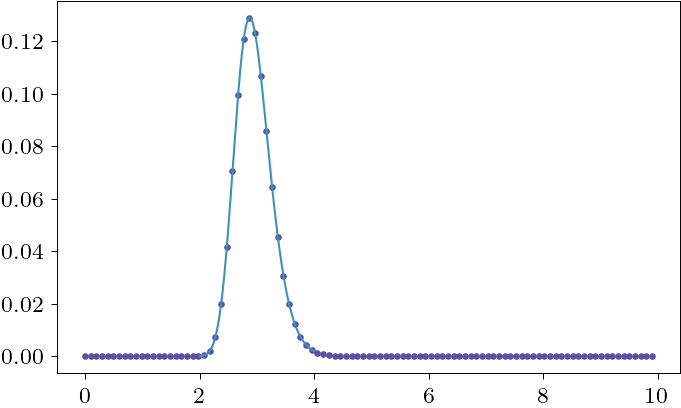

In [10]:
xnew = np.linspace(2, 4, 10000)
ynew = f(xnew)   # use interpolation function returned by `interp1d`
plt.plot(x, y, 'o', xnew, ynew, '-')

In [11]:
ymax = max(ynew)
halfmax = []
for i, yv in enumerate(ynew):
    if yv >= ymax/2:
        print(xnew[i], yv)
        halfmax.append(round(xnew[i],6))
        break
for i, yv in enumerate(ynew[::-1]):
    if yv >= ymax/2:
        print(xnew[-i], yv)
        halfmax.append(round(xnew[-i],6))
        break

2.5546554655465545 0.0644812899846291
3.267126712671267 0.06447171666436964


In [12]:
halfmax

[2.554655, 3.267127]

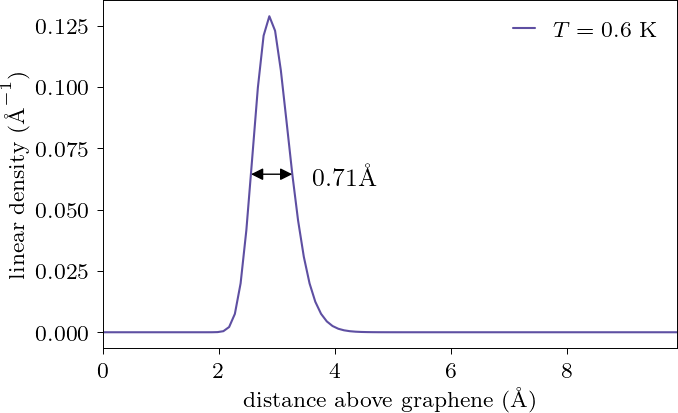

In [32]:
# totNlst, lin_lst, dz_lst = lin_ave(target)
# lx, ly, lz = target['boxdims'].iloc[0]

plt.style.reload_library()
with plt.style.context(plot_style['aps']):
    fig,ax = plt.subplots(figsize = (3.4646, 2.14122),constrained_layout=True)

#dgutils.fonts.set_custom_font(font_path)
    #plt.plot(xnew, ynew, '-', label=f'$T=0.6$ K', color=colors[0])
    plt.plot(np.arange(0,10-dz_lst[0],dz_lst[0]) ,np.array(lin_lst[0])*dz_lst[0]*lx*ly/target['n'].iloc[0],
         '-',label=f'$T=0.6$ K')
    #plt.plot(halfmax, [ymax/2, ymax/2], "x-", ms = 6)
    ax.annotate("",xy=(halfmax[0],ymax/2), xycoords='data',xytext=(halfmax[1],ymax/2),
                       arrowprops=dict(arrowstyle="<|-|>",color='k',lw=0.5,shrinkA=0.02,shrinkB=0.02))
    plt.text(3.6,0.06,str(round(halfmax[1]-halfmax[0],2))+r'${\rm \AA}$')
# for i in range(len(lin_lst)):
#     print(totNlst[i])
#     plt.plot(np.arange(0,10-dz_lst[i],dz_lst[i]) ,lin_lst[i], label=f'size={totNlst[i]}')
    plt.legend()
    ax.set_xlim(0,9.9)
    plt.xlabel('distance above graphene'+r' (${\rm \AA}$)')
    plt.ylabel('linear density' +r' (${\rm \AA}^{-1}$)')
    fig.savefig('../figures/linden15-93.pdf')
    fig.savefig('../figures/linden15-93.svg')

In [17]:
sum(lin_lst[0]*dz_lst[0]*lx*ly/target['n'].iloc[0])

0.9980996619806077